Max draw down of soft payouts: 24.94915091092146
% of positive clv: 0.536178107606679
count    539.000000
mean       0.063290
std        0.350489
min       -0.730120
25%       -0.165048
50%        0.038225
75%        0.264461
max        1.647472
dtype: float64
Expected/Actual wins: 120.48151868919389/124
Win percentage: 0.2300556586270872


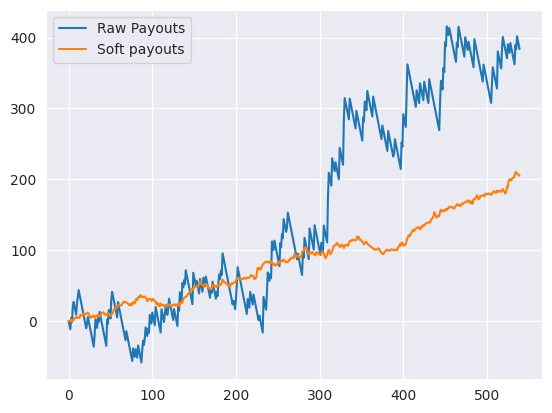

In [1]:
import os

from util.stats_calculator import get_max_draw_down
from typing import List
from util.plot import plot_wealth_growth
import pandas as pd
import csv

def row_to_live_result(row: List[str]) -> LiveResult:
    return LiveResult(float(row[0]), float(row[1]), row[3]=="True", stakes=float(row[2]))

with open('live_results.csv', newline='') as csvfile:
    live_result_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    
    live_results = [row_to_live_result(row) for row in live_result_reader]

clvs = [result.clv for result in live_results]
soft_payouts = [result.clv * result.stakes for result in live_results]
print(f"Max draw down of soft payouts: {get_max_draw_down(soft_payouts)}")
positive_clv_percentage = len([1 for payout in soft_payouts if payout > 0]) / len(soft_payouts)
print(f"% of positive clv: {positive_clv_percentage}")

payouts = [get_payout(result, result.stakes) for result in live_results]
print(pd.Series(clvs).describe())

expected_wins = sum([1 / live_result.starting_odds for live_result in live_results])
n_wins = sum([1 for live_result in live_results if live_result.has_won])
print(f"Expected/Actual wins: {expected_wins}/{n_wins}")
print(f"Win percentage: {n_wins / len(live_results)}")

plot_wealth_growth(payouts, label="Raw Payouts")
plot_wealth_growth(soft_payouts, label="Soft payouts")

8.0
8.024000000000001
8.1138688
8.142105063424001
8.082179170157199
8.009762844792592
7.94568474203425
7.960622629349275
8.123337755893173
7.827648261578662
7.822325460760788
8.090474777555668
8.111510011977312
8.13746684401564
8.12216840634889
8.238477857927807
8.303397063448278
8.333953564641769
8.33462028092694
8.501979456167952
8.188426453824478
8.715106043334469
8.722078128169136
8.828836364457926
9.860044451826612
10.04383568040866
9.711585596100742
9.687112400398568
10.072659473934431
9.871206284455742
10.501778941906775
Lowest bankroll: 1955.581365190197


<AxesSubplot:>

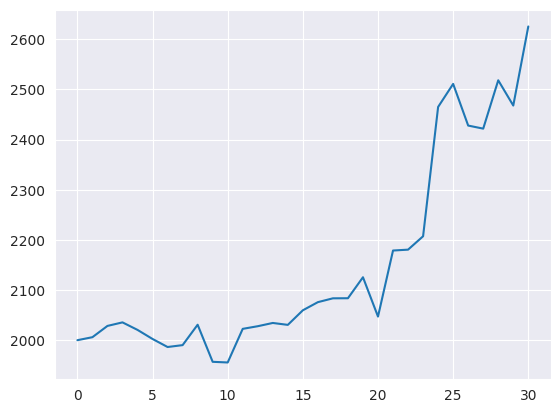

In [2]:
import csv
import seaborn as sns

STAKING_FRACTION = 0.004
bankroll = 2000
bankroll_snapshots = []

current_staking_size = max(STAKING_FRACTION * bankroll, 6)

with open('live_results.csv', newline='') as csvfile:
    live_result_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    
    profit_of_day = 0
    for row in live_result_reader:
        is_new_day = int(row[4]) == 1
        
        if is_new_day:
            bankroll += profit_of_day
            bankroll_snapshots.append(bankroll)
            profit_of_day = 0
            current_staking_size = max(STAKING_FRACTION * bankroll, 6)
            print(current_staking_size)
        
        offer_odds = float(row[0])
        has_won = row[3]=="True"
        
        profit_of_day -= current_staking_size
        if has_won:
            profit_of_day += offer_odds * current_staking_size

print(f"Lowest bankroll: {min(bankroll_snapshots)}")
sns.lineplot(bankroll_snapshots)

/home/daniel/PycharmProjects/WageringSystem/venv/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


bets_24_03.xlsx
['2024-03.json', '2024-04.json']


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]
/home/daniel/PycharmProjects/WageringSystem/venv/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


bets_24_04.xlsx
['2024-03.json', '2024-04.json']


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Max draw down of soft payouts: 22.437863925943986
% of positive clv: 0.515562649640862
count    100.000000
mean       0.032411
std        0.436912
min       -0.778858
25%       -0.272188
50%       -0.052680
75%        0.291536
max        1.525877
dtype: float64
Expected/Actual wins: 233.52935869656244/232
Win percentage: 0.18515562649640863
483.4889678858505


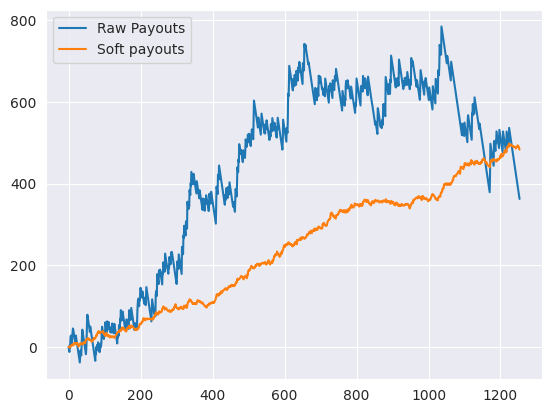

In [6]:
from Persistence.RaceCardPersistence import RaceDataPersistence
from Model.Betting.bet import LiveResult
from math import isnan
import os
import pandas as pd
from tqdm import tqdm
from util.stats_calculator import get_max_draw_down
from util.plot import plot_wealth_growth
from typing import List
from DataAbstraction.util.track_name_mapping import get_unique_track_name
from IPython.display import display

def get_live_results(live_bets_file_name: str) -> List[LiveResult]:
    header_row = 3
    bets_df = pd.read_excel(live_bets_file_name, header=header_row)
    
    name_pattern = r'/ (.*?) /'
    
    pattern = r'^(.*?)\s(\d{1,2})\s\w{3}\s/'
    
    bets_df['Name'] = bets_df['Description'].str.extract(name_pattern)
    bets_df["Name"] = bets_df["Name"].str.lower()
    
    # Use str.extract() to extract the track name, day, and month and create new columns
    bets_df[['Track', 'Day']] = bets_df['Description'].str.extract(pattern)
    bets_df["Track"] = bets_df["Track"].apply(get_unique_track_name)
    bets_df["Day"] = bets_df["Day"].astype(int)
    
    # display(bets_df[bets_df["Track"] == "Ascot"])
    
    race_cards_loader = RaceDataPersistence("race_cards_release")
    
    test_sample_file_names = race_cards_loader.race_data_file_names[-2:]
    
    print(test_sample_file_names)
    
    sp_data = {"Track": [], "Day": [], "Name": [], "SP": []}
    
    for race_card_file_name in tqdm(test_sample_file_names):
        race_cards = race_cards_loader.load_race_card_files_non_writable([race_card_file_name])
        for race_card in race_cards.values():
            for runner in race_card.runners:
                sp_data["Track"].append(race_card.track_name)
                sp_data["Day"].append(race_card.datetime.day)
                sp_data["Name"].append(runner.name.replace("'", "").lower())
                sp_data["SP"].append(runner.betfair_win_sp)
            
    sp_df = pd.DataFrame.from_dict(sp_data)
    bets_sp_df = pd.merge(bets_df, sp_df, on=["Track", "Day", "Name"], how="inner")
    
    live_results = []
    bets_sp_df = bets_sp_df.sort_values(by="Day")
    for row in bets_sp_df.itertuples(index=False):
        if isnan(row.SP):
            print(row)
        has_won = row.Status == "Won"
        win = 0
        if has_won:
            win = row.Stake * row.Odds
        live_results.append(LiveResult(row.Odds, row.SP, has_won, win=win, loss=row.Stake, stakes=row.Stake))
        
    return live_results
    
live_bets_dir = "../data/live_bets"
live_results = []
for live_bets_file_name in sorted(os.listdir(live_bets_dir)):
    print(live_bets_file_name)
    live_results += get_live_results(os.path.join(live_bets_dir, live_bets_file_name))
    
#---------------------------------------------------------
clvs = [result.clv for result in live_results]
soft_payouts = [result.clv * result.stakes for result in live_results]
print(f"Max draw down of soft payouts: {get_max_draw_down(soft_payouts)}")
positive_clv_percentage = len([1 for payout in soft_payouts if payout > 0]) / len(soft_payouts)
print(f"% of positive clv: {positive_clv_percentage}")

payouts = [result.payout for result in live_results]
print(pd.Series(clvs).describe())

expected_wins = sum([1 / live_result.starting_odds for live_result in live_results])
n_wins = sum([1 for live_result in live_results if live_result.has_won])
print(f"Expected/Actual wins: {expected_wins}/{n_wins}")
print(f"Win percentage: {n_wins / len(live_results)}")

plot_wealth_growth(payouts, label="Raw Payouts")
plot_wealth_growth(soft_payouts, label="Soft payouts")
print(sum(soft_payouts))

PearsonRResult(statistic=0.12944628668727948, pvalue=0.0010782102685377006)

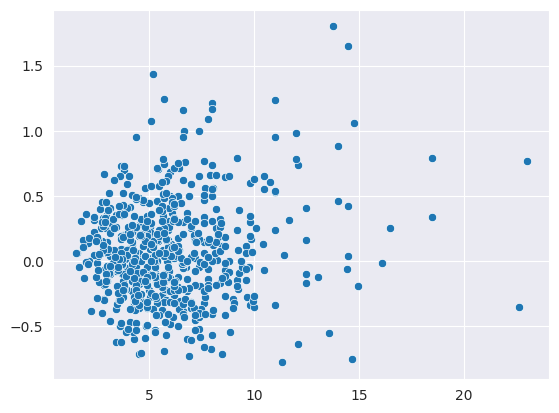

In [2]:
from scipy.stats import pearsonr
import seaborn as sns

offer_odds = [result.offer_odds for result in live_results]
sns.scatterplot(x=offer_odds, y=clvs)

pearsonr(x=offer_odds, y=clvs)